In [ ]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras import layers
import IPython
from tensorflow.keras.callbacks import EarlyStopping
import os
from pathlib import Path
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("uraninjo/augmented-alzheimer-mri-dataset")

print("Path to dataset files:", path)

# Original dataset directory (NonDemented only)
orig_dir = Path(path) / "OriginalDataset/NonDemented"

IMG_SIZE = (128, 128)
BATCH = 32
SEED = 42

# TRAIN on the NonDemented class
train_ds = tf.keras.utils.image_dataset_from_directory(
    orig_dir,
    labels=None, # self-supervised, no labels
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    color_mode="grayscale"
)

# VALIDATION on the NonDemented class
valid_ds = tf.keras.utils.image_dataset_from_directory(
    orig_dir,
    labels=None, # self-supervised, no labels
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    color_mode="grayscale"
)

Path to dataset files: /Users/redhaibbou/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1
Found 3200 files.
Using 2560 files for training.
Found 3200 files.
Using 640 files for validation.


In [ ]:
def to_self_supervised(ds):
    return ds.map(lambda x: (x, x))

train_ds_ae = to_self_supervised(train_ds)
valid_ds_ae  = to_self_supervised(valid_ds)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

train_ds_ae = train_ds_ae.map(
    lambda x, y: (normalization_layer(x), normalization_layer(y))
)
valid_ds_ae = valid_ds_ae.map(
    lambda x, y: (normalization_layer(x), normalization_layer(y))
)

train_ds_ae = train_ds_ae.cache().prefetch(tf.data.AUTOTUNE)
valid_ds_ae  = valid_ds_ae.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
img_height = 128
img_width  = 128
channels   = 1


def model_builder(hp):

    inputs = keras.Input(shape=(img_height, img_width, channels))
    x = inputs

    # Hyperparameters
    use_conv1 = hp.Boolean('use_conv1')
    use_conv2 = hp.Boolean('use_conv2')
    use_conv3 = hp.Boolean('use_conv3')
    use_conv4 = hp.Boolean('use_conv4')
    use_conv5 = hp.Boolean('use_conv5')

    filters1 = hp.Int('filters1', min_value=8,   max_value=16,  step=8)
    filters2 = hp.Int('filters2', min_value=16,  max_value=32,  step=16)
    filters3 = hp.Int('filters3', min_value=32,  max_value=64, step=32)
    filters4 = hp.Int('filters4', min_value=64,  max_value=128, step=64)
    filters5 = hp.Int('filters5', min_value=128, max_value=256, step=128)

    latent_units = hp.Int('latent_units', min_value=64, max_value=512, step=64)

    hidden_activation = hp.Choice('hidden_activation', ['relu', 'tanh', 'leaky_relu'])

    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)

    learning_rate = hp.Choice('learning_rate',
                              values=[1e-5, 3e-5, 1e-4, 3e-4, 5e-4, 1e-3, 3e-3])

    # ENCODER — dynamic structure
    conv_filters = [
        (use_conv1, filters1),
        (use_conv2, filters2),
        (use_conv3, filters3),
        (use_conv4, filters4),
        (use_conv5, filters5),
    ]

    block_count = 0
    used_filters = []   # IMPORTANT : record of actually used filters

    for use_flag, nf in conv_filters:
        if use_flag:
            x = keras.layers.Conv2D(nf, 3, padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
            x = keras.layers.MaxPooling2D(2)(x)
            used_filters.append(nf)
            block_count += 1

    # If no convolution layer is enabled → minimal fallback
    if block_count == 0:
        nf = 16
        x = keras.layers.Conv2D(nf, 3, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.MaxPooling2D(2)(x)
        used_filters.append(nf)
        block_count = 1

    # Final spatial size = 128 / (2^block_count)
    final_size = img_height // (2 ** block_count)

    encoded_shape = (final_size, final_size, used_filters[-1])
    x = keras.layers.Flatten()(x)

    # LATENT SPACE
    x = keras.layers.Dense(latent_units)(x)
    if hidden_activation == "leaky_relu":
        x = keras.layers.LeakyReLU()(x)
    else:
        x = keras.layers.Activation(hidden_activation)(x)

    x = keras.layers.Dropout(dropout_rate)(x)
    latent = x

    # DECODER (symmetric structure)
    nf = used_filters[-1]

    x = keras.layers.Dense(final_size * final_size * nf, activation='relu')(latent)
    x = keras.layers.Reshape(encoded_shape)(x)

    # Upsampling reconstruction using the actually used filters (reversed order)
    for nf_dec in reversed(used_filters):
        x = keras.layers.Conv2DTranspose(
            nf_dec,
            3,
            strides=2,
            padding='same',
            activation='relu'
        )(x)

    # Final output (same shape as the input)
    outputs = keras.layers.Conv2DTranspose(
        channels,
        3,
        padding='same',
        activation='sigmoid'
    )(x)

    autoencoder = keras.Model(inputs, outputs)

    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss='mse',
        metrics=['mse']
    )

    return autoencoder

In [ ]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_loss',
    max_trials=50,
    executions_per_trial=1,
    directory='CutePoison-AE',
    project_name='Alzheimer'
)

In [ ]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    # The on_train_end method is called at the end of model training
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Search for the best hyperparameters
tuner.search(
    train_ds_ae,
    epochs=50,
    validation_data=valid_ds_ae,
    callbacks=[ClearTrainingOutput(), early_stop]
)

# Retrieve the best set of hyperparameters found by the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Structured display of the optimal architecture proposed by Keras Tuner
print("\nOptimal architecture found by Keras Tuner :")

# Display which convolutional layers are enabled
print(f"  Couches de convolution activées :")
print(f"    - Conv1 (1st layer)    : {best_hps.get('use_conv1')}")
print(f"    - Conv2 (2nd layer)    : {best_hps.get('use_conv2')}")
print(f"    - Conv3 (3rd layer)    : {best_hps.get('use_conv3')}")
print(f"    - Conv4 (4th layer)    : {best_hps.get('use_conv4')}")
print(f"    - Conv5 (5th layer)    : {best_hps.get('use_conv5')}")

# Conditional display of parameters for each convolutional layer
if best_hps.get('use_conv1'):
    print(f"    → Conv1 filters       : {best_hps.get('filters1')}")
if best_hps.get('use_conv2'):
    print(f"    → Conv2 filters       : {best_hps.get('filters2')}")
if best_hps.get('use_conv3'):
    print(f"    → Conv3 filters        : {best_hps.get('filters3')}")
if best_hps.get('use_conv4'):
    print(f"    → Conv4 filters        : {best_hps.get('filters4')}")
if best_hps.get('use_conv5'):
    print(f"    → Conv5 filters        : {best_hps.get('filters5')}")

# Final dense layer
print("\n  Final dense layer :")
print(f"    - Neurones          : {best_hps.get('latent_units')}")
print(f"    - Activation        : {best_hps.get('hidden_activation')}")

# Dropout
print(f"\n  Dropout rate : {best_hps.get('dropout_rate')}")

# Learning rate
print(f"\n  Optimization :")
print(f"    - Learning rate : {best_hps.get('learning_rate')}")

Trial 50 Complete [00h 05m 54s]
val_loss: 0.004479803144931793

Best val_loss So Far: 0.002011931035667658
Total elapsed time: 11h 19m 39s

Architecture optimale trouvée par Keras Tuner :
  Couches de convolution activées :
    - Conv1 (1ère couche)  : True
    - Conv2 (2e couche)    : False
    - Conv3 (3e couche)    : False
    - Conv4 (4e couche)    : False
    - Conv5 (5e couche)    : True
    → Filtres Conv1        : 8
    → Filtres Conv5        : 256

  Couche dense finale :
    - Neurones          : 128
    - Activation        : relu

  Taux de dropout : 0.2

  Optimisation :
    - Taux d'apprentissage : 0.0001


In [ ]:
model = model_builder(best_hps)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 8)    │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 8)    │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 256)    │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    33,554,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 262144)         │    33,816,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 64, 64, 256)    │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 128, 128, 8)    │        18,440 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 128, 128, 1)    │            73 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,999,553 (259.40 MB)

 Trainable params: 67,999,025 (259.40 MB)

 Non-trainable params: 528 (2.06 KB)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('mse') < 0.002): # Si la mse est inférieur strictement à 0.002
            print("\nLess than 0.002 mse so cancelling training!")
            self.model.stop_training = True # Arrêter l'entraînement

In [ ]:
history = model.fit(
    train_ds_ae,
    validation_data=valid_ds_ae,
    epochs=100,
    callbacks=[myCallback()]
)

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 47s 565ms/step - loss: 0.0566 - mse: 0.0566 - val_loss: 0.1012 - val_mse: 0.1012
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 562ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0860 - val_mse: 0.0860
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 563ms/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0726 - val_mse: 0.0726
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 560ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0510 - val_mse: 0.0510
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 560ms/step - loss: 0.0103 - mse: 0.0103 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 562ms/step - loss: 0.0099 - mse: 0.0099 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 558ms/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 559ms/step - loss: 0.0093 - mse: 0.0093 - val_loss: 0.0095 - val_mse: 0.0095
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
model_filename = "best_auto-encodeur.keras"

if os.path.exists(model_filename):
    os.remove(model_filename)  # Deletes the old file/folder
    print(f"🗑️ Old file '{model_filename}' supprimé.")

In [ ]:
model.save(model_filename)
print(f"✅ New model save as '{model_filename}'")

✅ Nouveau modèle sauvegardé sous le nom 'meilleur_auto-encodeur.keras'


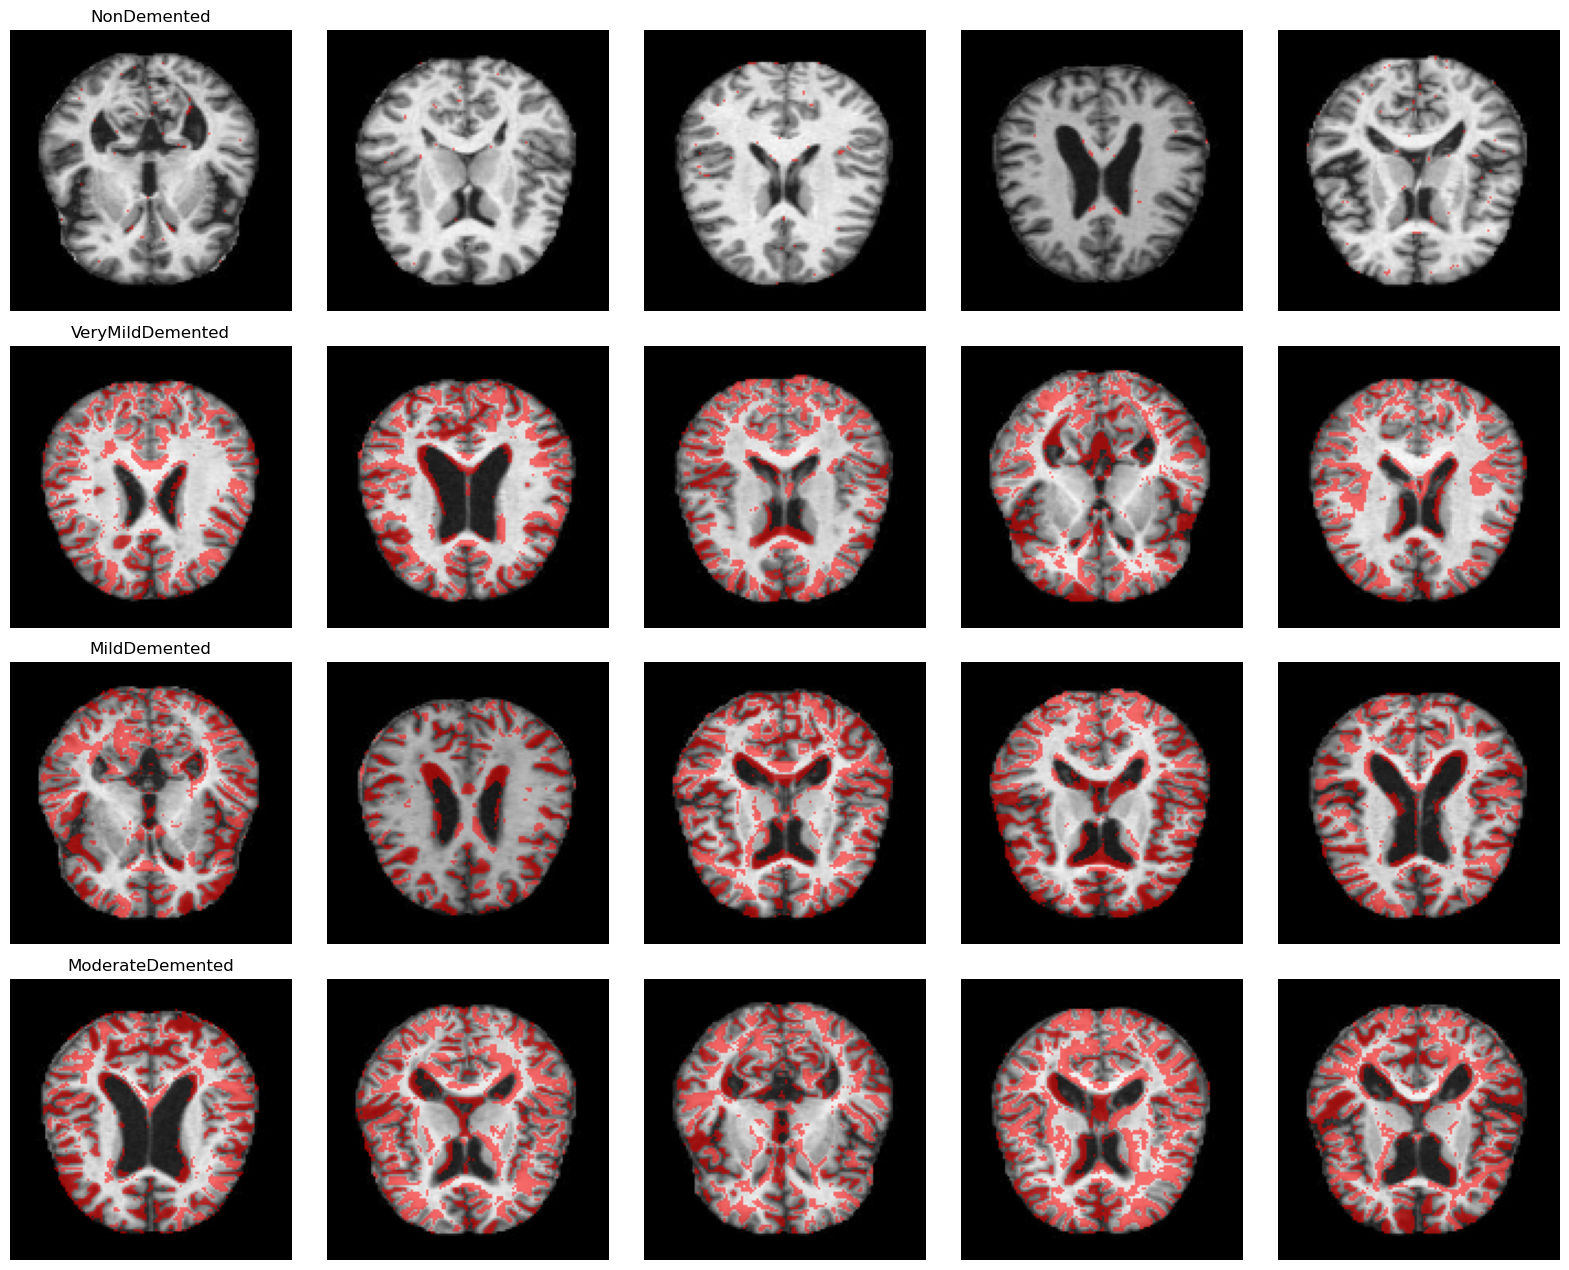

In [ ]:
def list_image_files(folder: Path):
    # Accepted image extensions.
    exts = ("*.png", "*.jpg", "*.jpeg", "*.bmp")
    files = []
    for e in exts:
        files.extend(folder.glob(e))
    return sorted(files)


# Loads a grayscale image, resizes it to 128x128, and normalizes it to [0,1].
def load_grayscale_128(fp: str):
    img_bytes = tf.io.read_file(fp)
    img = tf.io.decode_image(img_bytes, channels=1, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, method="bilinear")
    # Casts to float32 and normalizes to [0,1] by dividing by 255.
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.ensure_shape(img, [IMG_SIZE[0], IMG_SIZE[1], 1])
    return img


# Randomly samples k files from a list, without replacement, using a reproducible seed.
def sample_files(files, k, seed=42):
    rng = np.random.default_rng(seed)
    if len(files) < k:
        raise ValueError(f"Not enough images: requested {k}, found {len(files)}")
    idx = rng.choice(len(files), size=k, replace=False)
    return [str(files[i]) for i in idx]


# Calibrates a pixel-wise anomaly threshold using reconstructions of "healthy" (NonDemented) images.
def estimate_error_threshold_from_normal(model, normal_dir: Path, n_calib=200, q=0.995, seed=42):

    normal_files = list_image_files(normal_dir)
    n_calib = min(n_calib, len(normal_files))
    calib_fps = sample_files(normal_files, n_calib, seed=seed)

    # Loads and stacks images to form a batch (B,H,W,1).
    imgs = tf.stack([load_grayscale_128(fp) for fp in calib_fps], axis=0)

    # Reconstructs images using the autoencoder (output has same shape as input).
    recons = model.predict(imgs, verbose=0)

    # Computes pixel-wise absolute reconstruction error: |x - x_hat|.
    err = np.abs(imgs.numpy() - recons)

    # Flattens all errors and takes the q-quantile (e.g., 99.5th percentile).
    # → a high threshold: only truly atypical pixels exceed it.
    return float(np.quantile(err.reshape(-1), q))


# Anomaly map + red overlay
# Creates an RGB image where anomalous pixels are highlighted in red over the grayscale image.
def make_overlay(img01, err_map, thr, alpha=0.55):

    # Removes the channel dimension (1) → (H,W) for easier NumPy operations.
    img = img01.squeeze(-1)

    # Creates a binary mask: 1 if error > threshold, else 0.
    mask = (err_map.squeeze(-1) > thr).astype(np.float32)

    # Converts the grayscale image (H,W) to RGB (H,W,3) by duplicating channels.
    base = np.stack([img, img, img], axis=-1)

    # Creates a pure red image (H,W,3): R=1, G=0, B=0.
    red = np.zeros_like(base)
    red[..., 0] = 1.0

    overlay = base * (1 - alpha * mask[..., None]) + red * (alpha * mask[..., None])

    return np.clip(overlay, 0, 1)


# Computes the threshold thr from NonDemented (healthy) images.
thr = estimate_error_threshold_from_normal(
    model,
    normal_dir=NonDemented,  # healthy directory used for threshold calibration
    n_calib=300,             # number of healthy images used for calibration
    q=0.995,                 # high quantile (99.5%) → strict threshold
    seed=SEED                # seed for reproducibility
)


fig, axes = plt.subplots(len(CLASSES), N_SHOW, figsize=(3.2 * N_SHOW, 3.2 * len(CLASSES)))

if len(CLASSES) == 1:
    axes = np.expand_dims(axes, axis=0)

if N_SHOW == 1:
    axes = np.expand_dims(axes, axis=1)

# Loop over classes: r = row index, cls_name = display name, cls_dir = directory.
for r, (cls_name, cls_dir) in enumerate(CLASSES):
    files = list_image_files(cls_dir)

    chosen = sample_files(files, N_SHOW, seed=SEED + r)
    imgs = tf.stack([load_grayscale_128(fp) for fp in chosen], axis=0)

    # Reconstructs images using the autoencoder.
    recons = model.predict(imgs, verbose=0)

    # Computes pixel-wise absolute reconstruction error for each image.
    err = np.abs(imgs.numpy() - recons)

    # Loop over the N_SHOW images of the class.
    for c in range(N_SHOW):
        overlay = make_overlay(imgs.numpy()[c], err[c], thr, alpha=0.55)
        ax = axes[r, c]
        ax.imshow(overlay)
        ax.axis("off")

        # Displays the class name only on the first column.
        if c == 0:
            ax.set_title(cls_name, fontsize=12)

plt.tight_layout()
plt.show()

### **1. NonDemented (healthy subjects)**

Images from NonDemented subjects show very few regions highlighted in red.
The few detected pixels mainly correspond to reconstruction noise or normal anatomical variations.

This indicates that the autoencoder, trained exclusively on healthy brains, reconstructs this type of image accurately, with low and localized reconstruction error.
This behavior is expected and reflects a low false-positive rate.

---

### **2. VeryMildDemented (very mild dementia)**

For VeryMildDemented subjects, red regions appear in a subtle but consistent manner, mainly around the cortex and near the ventricles.

These anomalies remain limited and non-uniform, reflecting subtle structural changes compared to healthy brains.
This result is consistent with clinical reality, where anatomical changes at this stage are early, diffuse, and difficult to detect visually.

---

### **3. MildDemented (mild dementia)**

At the MildDemented stage, red regions become more frequent and more spatially extended.
Reconstruction errors increasingly affect the cortex as well as some internal brain structures.

This reflects a progressive increase in morphological and textural differences compared to healthy images.
The transition from the VeryMild stage is clearly visible, indicating a gradual degradation of the model’s reconstruction ability.

---

### **4. ModerateDemented (moderate dementia)**

Images from ModerateDemented subjects show red regions widely distributed across the brain.
Reconstruction error becomes high and almost global.

At this stage, brain structure deviates significantly from the healthy pattern learned by the autoencoder.
This behavior is consistent with moderate dementia, which is clinically characterized by diffuse cerebral atrophy.

---

### 🧠 **Global interpretation**

The reconstruction error maps show a clear and gradual progression of anomalies from the healthy stage to more advanced dementia stages.
The regions highlighted in red do not represent precise medical lesions, but rather areas where brain structure diverges from the healthy pattern learned by the autoencoder.

This approach provides a meaningful visualization of global structural deviations and fits within an exploratory anomaly detection framework for brain MRI analysis.